In [4]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AfgeXvsuZX7EF_FIqgFoldJyAkpLPINQ1Nt-bQ1UBbWotfq2hFXNb0BbuIU

Successfully saved authorization token.


In [67]:
def clipper(image, shp_file):
    return image.clip(shp_file)

def spei(dataset):
    precipitation = dataset.select('pr').rename('Pp')
    pet = dataset.select('pet').multiply(0.1).rename('PET')
    
    time = dataset.get('system:time_start')
    
    return precipitation.subtract(pet).multiply(0.01).rename('SPEI').set('system:time_start', time)

In [68]:
shp_argentina = ee.FeatureCollection('users/adelarja/Hidro2022/Prov_Arg')

In [69]:
start_date = ee.Date.fromYMD(2000, 1, 1)
end_date = ee.Date.fromYMD(2020, 1, 1)

In [70]:
dataset = ee.ImageCollection(
    'IDAHO_EPSCOR/TERRACLIMATE').filterDate(
    start_date, end_date).map(
    lambda x: clipper(x, shp_argentina)
)

dataset_spei = dataset.map(spei)

In [77]:
 palette = [
    '1a3678', '2955bc', '5699ff', '8dbae9', 'acd1ff', 'caebff', 'e5f9ff',
    'fdffb4', 'ffe6a2', 'ffc969', 'ffa12d', 'ff7c1f', 'ca531a', 'ff0000',
    'ab0000'
]
palette = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
petVis = {
    'min': -2,
    'max': 2,
    'palette': palette
}

In [78]:
import folium

# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)

        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)

        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)

        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))


# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [81]:
lat, lon = -34.603722, -58.381592

my_map = folium.Map(location=[lat, lon], zoom_start=5)

my_map.add_ee_layer(dataset_spei.select('SPEI').mean(), petVis, "SPEI")
my_map.add_ee_layer(shp_argentina, {}, "Argentina")
my_map.add_child(folium.LayerControl())
display(my_map)

In [95]:
import ipygee as ui

roi = ee.Geometry.Point([-59.88 , -36.83])

chart = ui.chart.Image.series(
    **{
        'imageCollection': dataset_spei.select('SPEI'),
        'region': roi,
        'reducer': ee.Reducer.mean(),
        'scale': 4638.3
    }
)

chart.renderWidget()

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

### Vamos a convertir la data de gee a dataset para luego poder graficar con matplotlib

In [99]:
scale = 4638.3
spei = dataset_spei.select('SPEI').getRegion(roi, scale).getInfo()

In [105]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [111]:
spei_df = ee_array_to_df(spei, ['SPEI'])

In [112]:
spei_df

,time,datetime,SPEI
0,946684800000,2000-01-01,-1.045
1,949363200000,2000-02-01,0.230
2,951868800000,2000-03-01,0.075
3,954547200000,2000-04-01,0.418
4,957139200000,2000-05-01,0.719
...,...,...,...
235,1564617600000,2019-08-01,-0.602
236,1567296000000,2019-09-01,-0.730
237,1569888000000,2019-10-01,-0.524
238,1572566400000,2019-11-01,-1.195


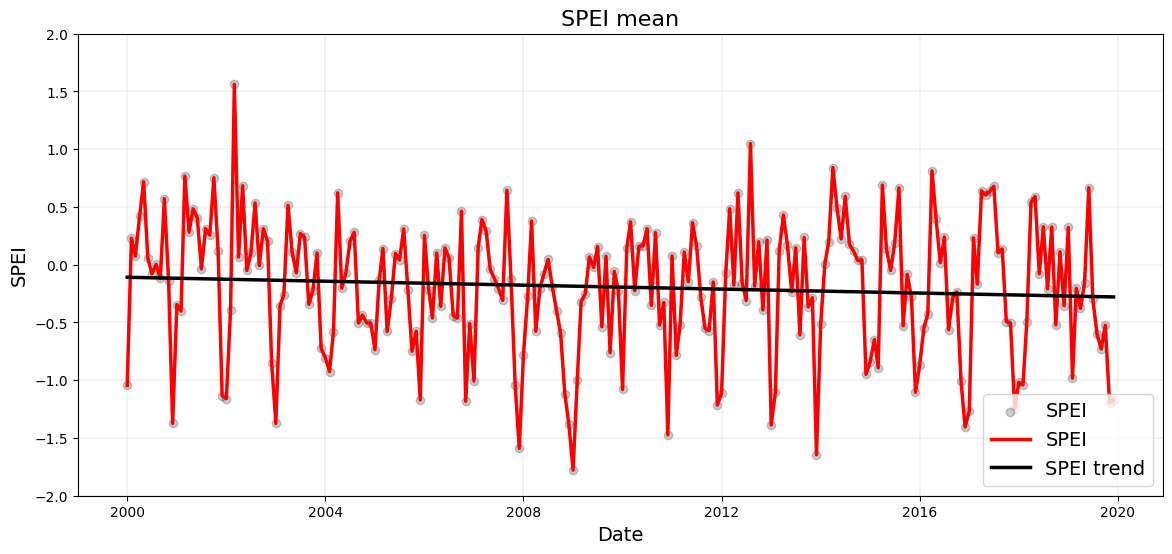

In [138]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data = np.asanyarray(spei_df['time'].apply(float))  # Time

## Secondly, extract y values (SPEI) from the dfs.
y_data = np.asanyarray(spei_df['SPEI'].apply(float))  # SPEI

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(spei_df['datetime'], spei_df['SPEI'],
           c='black', alpha=0.2, label='SPEI')

# Add fitting curves.
ax.plot(spei_df['datetime'],
        spei_df['SPEI'],
        label='SPEI', color='red', lw=2.5)

# Add trend curves.
z = np.polyfit(list(spei_df.index), spei_df['SPEI'], 1)
p = np.poly1d(z)

ax.plot(spei_df['datetime'],
        p(spei_df.index),
        label='SPEI trend', color='black', lw=2.5)

# Add some parameters.
ax.set_title('SPEI mean', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('SPEI', fontsize=14)
ax.set_ylim(-2, 2)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [141]:
def add_variables(image):
    time_field = 'system:time_start'
    
    date = ee.Date(image.get(time_field))
    years = date.difference(ee.Date('1970-01-01'), 'year')
    
    return image.addBands(ee.Image(years).rename('t')).float().addBands(ee.Image.constant(1))

In [147]:
time_field = 'system:time_start'
filtered_spei = dataset_spei.select('SPEI').filterBounds(roi).map(add_variables)

independents = ee.List(['constant', 't'])
dependent = ee.String('SPEI')

trend = filtered_spei.select(independents.add(dependent)).reduce(ee.Reducer.linearRegression(independents.length(), 1))
coefficients = trend.select('coefficients').arrayProject([0]).arrayFlatten([independents])

In [153]:
detrended = filtered_spei.map(lambda image: image.select(dependent).subtract(image.select(independents).multiply(coefficients).reduce('sum')).rename(dependent).copyProperties(image, [time_field]))

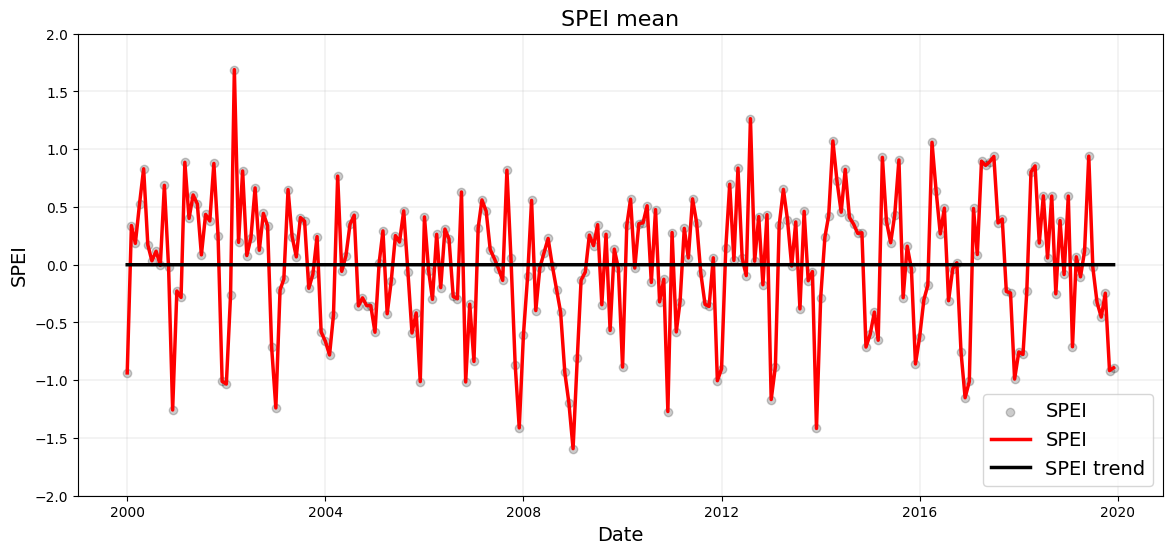

In [155]:
scale = 4638.3
detrended_spei = detrended.select('SPEI').getRegion(roi, scale).getInfo()
spei_df = ee_array_to_df(detrended_spei, ['SPEI'])

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data = np.asanyarray(spei_df['time'].apply(float))  # Time

## Secondly, extract y values (SPEI) from the dfs.
y_data = np.asanyarray(spei_df['SPEI'].apply(float))  # SPEI

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(spei_df['datetime'], spei_df['SPEI'],
           c='black', alpha=0.2, label='SPEI')

# Add fitting curves.
ax.plot(spei_df['datetime'],
        spei_df['SPEI'],
        label='SPEI', color='red', lw=2.5)

# Add trend curves.
z = np.polyfit(list(spei_df.index), spei_df['SPEI'], 1)
p = np.poly1d(z)

ax.plot(spei_df['datetime'],
        p(spei_df.index),
        label='SPEI trend', color='black', lw=2.5)

# Add some parameters.
ax.set_title('SPEI mean', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('SPEI', fontsize=14)
ax.set_ylim(-2, 2)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()